In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

from datetime import timedelta

In [2]:
# 대형 온라인 샵의 7개월(2019 10월 ~ 2020년 4월) 행동 데이터
big_behavior = pd.read_csv('ecommerce/2019-Nov.csv')

**온라인 매장 행동 데이터**

In [3]:
big_behavior.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
big_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [5]:
big_behavior.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

In [6]:
# 결측치 제거
big_behavior.dropna(axis=0, inplace=True)

In [7]:
# datetime화 시간대 정보 제거
big_behavior['event_time'] = pd.to_datetime(big_behavior['event_time']).dt.tz_convert(None)

**사이트 체류 시간 계산**

In [8]:
hd_df = big_behavior[['event_time', 'user_id', 'user_session', 'event_type']]
hd_df.head()

,event_time,user_id,user_session,event_type
0,2019-11-01 00:00:00,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,view
1,2019-11-01 00:00:00,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,view
3,2019-11-01 00:00:01,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,view
4,2019-11-01 00:00:01,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,view
5,2019-11-01 00:00:01,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,view


In [9]:
# 동일한 세션에 대해 마지막, 처음 시간에 대한 df 생성
max_group = hd_df.groupby(['user_session', 'user_id'], as_index=True)['event_time'].max()
min_group = hd_df.groupby(['user_session', 'user_id'], as_index=True)['event_time'].min()

In [10]:
# 열 이름 변경
max_time_df = pd.DataFrame(max_group)
max_time_df.columns = ['latest']

min_time_df = pd.DataFrame(min_group)
min_time_df.columns = ['start']

In [11]:
# 가장 최근 접속 시간
display(max_time_df.head())
# 처음  접속 시간
display(min_time_df.head())

,,latest
user_session,user_id,
0000009d-1f5b-40b9-bd23-db4f3d973ae3,457789173,2019-11-13 06:02:54
000001d5-f8f8-4e40-b8d6-224155713521,569353390,2019-11-09 13:58:06
00000510-834a-498a-9bed-561a90c5125e,513196170,2019-11-02 13:29:04
00000616-f016-4c01-b323-438486d9d3ee,518709589,2019-11-17 05:39:59
000007b4-6d31-4590-b88f-0f68d1cee73c,572115980,2019-11-16 08:12:52


,,start
user_session,user_id,
0000009d-1f5b-40b9-bd23-db4f3d973ae3,457789173,2019-11-13 06:02:54
000001d5-f8f8-4e40-b8d6-224155713521,569353390,2019-11-09 13:58:06
00000510-834a-498a-9bed-561a90c5125e,513196170,2019-11-02 13:29:04
00000616-f016-4c01-b323-438486d9d3ee,518709589,2019-11-17 05:36:28
000007b4-6d31-4590-b88f-0f68d1cee73c,572115980,2019-11-16 08:11:45


In [12]:
# 두 df 연결
session_df = pd.concat([max_time_df, min_time_df], axis=1)
# 세션별 사이트 체류시간 계산
session_df['session_time'] = session_df['latest'] - session_df['start']

In [13]:
# 비정상 데이터 처리
session_df = session_df.loc[session_df['session_time']<pd.Timedelta(days=1)]
session_df['session_time'].value_counts()

session_time
0 days 00:00:00    3537795
0 days 00:00:23      27595
0 days 00:00:26      27572
0 days 00:00:25      27571
0 days 00:00:21      27390
                    ...   
0 days 10:36:01          1
0 days 23:00:21          1
0 days 05:22:56          1
0 days 06:49:13          1
0 days 08:40:19          1
Name: count, Length: 24206, dtype: int64

In [14]:
session_df.sort_values('session_time', ascending=False)

,,latest,start,session_time
user_session,user_id,,,
a420656b-46be-40e4-82a2-0b704fd76cd5,572811312,2019-11-26 03:07:35,2019-11-25 03:07:38,0 days 23:59:57
bfbcd7fd-3cf8-4fc6-8488-8a76bede48e7,576913243,2019-11-28 02:34:22,2019-11-27 02:34:25,0 days 23:59:57
c445cd4f-71ec-4811-aa65-f67b9205a535,516294321,2019-11-23 08:14:32,2019-11-22 08:14:35,0 days 23:59:57
cd0ff507-f25a-4c6e-9176-29c9e05fdb75,572811312,2019-11-26 03:07:39,2019-11-25 03:07:43,0 days 23:59:56
2101acb6-c605-4db6-864a-6d0afddeec3f,574276662,2019-11-22 12:33:37,2019-11-21 12:33:48,0 days 23:59:49
...,...,...,...,...
7c6b9251-bbd5-42f5-8f63-752a865d9110,566657705,2019-11-12 12:07:28,2019-11-12 12:07:28,0 days 00:00:00
7c6b9127-545b-4dc4-a798-7eb0fcc42a75,514856494,2019-11-27 09:35:38,2019-11-27 09:35:38,0 days 00:00:00
7c6b9034-c2b2-482c-bb44-6d5e68de90c2,540815058,2019-11-08 02:52:48,2019-11-08 02:52:48,0 days 00:00:00


In [15]:
# 정상 데이터 user_id
user_id_list = list(session_df.reset_index(drop=False)['user_id'].unique())
user_id_list[:5]

[457789173, 569353390, 513196170, 518709589, 572115980]

**DAU 확인위한 전처리**

In [16]:
# 일별 활성 사용자 수 위한 utc_day 열 생성
behavior_df = big_behavior.loc[big_behavior['user_id'].isin(user_id_list)]
utc_day = []
for time in behavior_df['event_time']:
    utc_day.append(time.day)
# utc_day 열 추가
behavior_df['utc_day'] = utc_day
behavior_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,utc_day
0,2019-11-01 00:00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,1
1,2019-11-01 00:00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,1
3,2019-11-01 00:00:01,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,1
4,2019-11-01 00:00:01,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,1
5,2019-11-01 00:00:01,view,1306894,2053013558920217191,computers.notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,1


In [17]:
# uct_day 컬럼 생성 및 분리
day_df = behavior_df[['user_id', 'utc_day']]
day_df.head()

,user_id,utc_day
0,520088904,1
1,530496790,1
3,518085591,1
4,558856683,1
5,520772685,1


**DAU 확인**

In [18]:
# 일자별 user_id 그룹화를 통한 일별 활성 사용자 수(DAU) 확인
day_df.drop_duplicates(inplace=True)
grouped = day_df.groupby('utc_day', as_index=False).size()
grouped

,utc_day,size
0,1,160584
1,2,167619
2,3,174291
3,4,197636
4,5,182881
5,6,178957
6,7,194431
7,8,205722
8,9,193287
9,10,199936


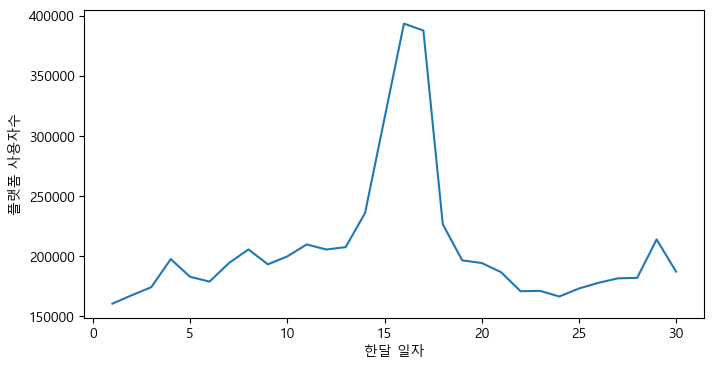

In [19]:
plt.figure(figsize=(8,4))
sns.lineplot(x='utc_day', y='size', data=grouped)
plt.xlabel('한달 일자')
plt.ylabel('플랫폼 사용자수')
plt.show()

**16일이 DAU가 가장 많음**

**Funnel 분석**

In [20]:
sep_hd_df = big_behavior.loc[big_behavior['user_id'].isin(user_id_list)][['event_time', 'event_type', 'user_session', 'price']]
sep_hd_df.head()

,event_time,event_type,user_session,price
0,2019-11-01 00:00:00,view,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,489.07
1,2019-11-01 00:00:00,view,8e5f4f83-366c-4f70-860e-ca7417414283,293.65
3,2019-11-01 00:00:01,view,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,712.87
4,2019-11-01 00:00:01,view,313628f1-68b8-460d-84f6-cec7a8796ef2,183.27
5,2019-11-01 00:00:01,view,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,360.09


In [21]:
# 세션 id와 이벤트 타임을 기준으로 groupby해 최초 접속 
group = sep_hd_df.groupby(['user_session', 'event_type'], as_index=True)['event_time'].min()
# 세션 id와 이벤트 타임을 기준으로 groupby해 평균 가격대 계산
group_price = sep_hd_df.groupby(['user_session', 'event_type'], as_index=True)['price'].mean()
# funnel 스탭을 위한 별도의 df 생성
funnel_steps = pd.DataFrame({'steps':[1,2,3]}, index=['view', 'cart', 'purchase'])

# group df와 funnel 스탭 df, group_price df 결합
group = pd.DataFrame(group).merge(funnel_steps, left_on='event_type', right_index=True)
group_df = pd.DataFrame(group_price).merge(group, on=['user_session', 'event_type'], how='inner')

In [22]:
# 세션 id별로 다음 단계로의 진행 여부 확인
funnel_event_time = group.reset_index().pivot(index='user_session', columns='steps', values='event_time')
funnel_event_time.columns = funnel_steps.index
funnel_event_time

,view,cart,purchase
user_session,,,
0000009d-1f5b-40b9-bd23-db4f3d973ae3,2019-11-13 06:02:54,NaT,NaT
000001d5-f8f8-4e40-b8d6-224155713521,2019-11-09 13:58:06,NaT,NaT
00000510-834a-498a-9bed-561a90c5125e,2019-11-02 13:29:04,NaT,NaT
00000616-f016-4c01-b323-438486d9d3ee,2019-11-17 05:36:28,NaT,NaT
000007b4-6d31-4590-b88f-0f68d1cee73c,2019-11-16 08:11:45,NaT,NaT
...,...,...,...
fffff826-edc8-4d19-9dd7-936ef133bc89,2019-11-22 02:21:34,NaT,NaT
fffff956-3426-4d37-9de9-4c00ec4ddeac,2019-11-13 03:09:08,NaT,NaT
fffffbbe-9f76-403b-b17c-e7c68c48ea1c,2019-11-17 09:43:04,NaT,NaT


- funnel 수치 계산 / 시각화

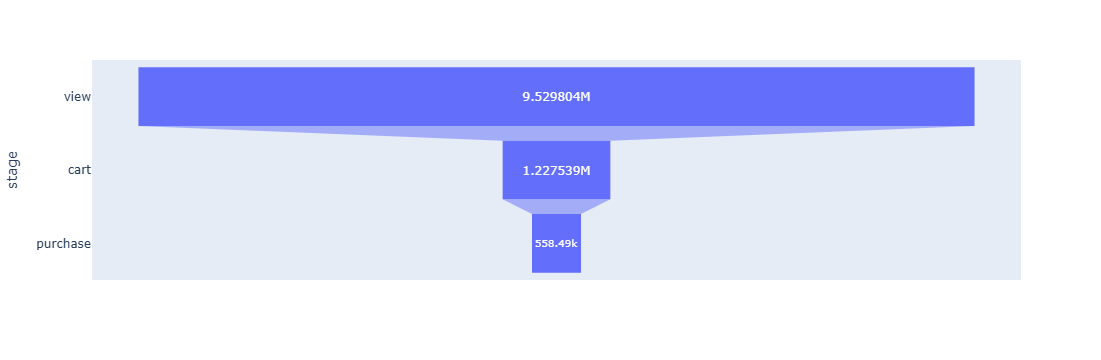

In [33]:
step_values = [funnel_event_time[col].notna().sum() for col in funnel_event_time.columns]

# funnel 수치 시각화
data = dict(number=step_values, 
            stage=list(funnel_event_time.columns))
fig = px.funnel(data, x='number', y='stage')
fig.show()

In [23]:
# 세션 id별로 다음 단계로의 진행 여부 확인
funnel_price = group_df.reset_index().pivot(index='user_session', columns='steps', values='price')
funnel_price.columns = funnel_steps.index
funnel_price

,view,cart,purchase
user_session,,,
0000009d-1f5b-40b9-bd23-db4f3d973ae3,1422.100000,NaN,NaN
000001d5-f8f8-4e40-b8d6-224155713521,308.630000,NaN,NaN
00000510-834a-498a-9bed-561a90c5125e,69.170000,NaN,NaN
00000616-f016-4c01-b323-438486d9d3ee,905.213333,NaN,NaN
000007b4-6d31-4590-b88f-0f68d1cee73c,509.563333,NaN,NaN
...,...,...,...
fffff826-edc8-4d19-9dd7-936ef133bc89,317.860000,NaN,NaN
fffff956-3426-4d37-9de9-4c00ec4ddeac,279.850625,NaN,NaN
fffffbbe-9f76-403b-b17c-e7c68c48ea1c,260.925000,NaN,NaN


In [24]:
# 새로운 price 열 생성: view 가격을 사용하고, NaN인 경우 cart 또는 purchase 가격을 사용
funnel_price['price'] = funnel_price['view'].combine_first(funnel_price['cart']).combine_first(funnel_price['purchase'])

# 필요한 열만 남기기
funnel_price = funnel_price[['price']]

funnel_price

,price
user_session,
0000009d-1f5b-40b9-bd23-db4f3d973ae3,1422.100000
000001d5-f8f8-4e40-b8d6-224155713521,308.630000
00000510-834a-498a-9bed-561a90c5125e,69.170000
00000616-f016-4c01-b323-438486d9d3ee,905.213333
000007b4-6d31-4590-b88f-0f68d1cee73c,509.563333
...,...
fffff826-edc8-4d19-9dd7-936ef133bc89,317.860000
fffff956-3426-4d37-9de9-4c00ec4ddeac,279.850625
fffffbbe-9f76-403b-b17c-e7c68c48ea1c,260.925000


In [25]:
# 두 피벗 테이블 합치기
funnel = pd.concat([funnel_event_time, funnel_price], axis=1, keys=['event_time', 'price'])

funnel

event_time                      \
                                                    view                cart   
user_session                                                                   
0000009d-1f5b-40b9-bd23-db4f3d973ae3 2019-11-13 06:02:54                 NaT   
000001d5-f8f8-4e40-b8d6-224155713521 2019-11-09 13:58:06                 NaT   
00000510-834a-498a-9bed-561a90c5125e 2019-11-02 13:29:04                 NaT   
00000616-f016-4c01-b323-438486d9d3ee 2019-11-17 05:36:28                 NaT   
000007b4-6d31-4590-b88f-0f68d1cee73c 2019-11-16 08:11:45                 NaT   
...                                                  ...                 ...   
fffff826-edc8-4d19-9dd7-936ef133bc89 2019-11-22 02:21:34                 NaT   
fffff956-3426-4d37-9de9-4c00ec4ddeac 2019-11-13 03:09:08                 NaT   
fffffbbe-9f76-403b-b17c-e7c68c48ea1c 2019-11-17 09:43:04                 NaT   
fffffd01-5f95-4916-b2dd-491c603d6c9c 2019-11-17 14:07:11 2019-11-17 14:07:42   
fffffde2-4522-4b44-8a32-510c55739ba1 2019-11-30 10:29:57                 NaT   

                                                                price  
                                                purchase        price  
user_session                                                           
0000009d-1f5b-40b9-bd23-db4f3d973ae3                 NaT  1422.100000  
000001d5-f8f8-4e40-b8d6-224155713521                 NaT   308.630000  
00000510-834a-498a-9bed-561a90c5125e                 NaT    69.170000  
00000616-f016-4c01-b323-438486d9d3ee                 NaT   905.213333  
000007b4-6d31-4590-b88f-0f68d1cee73c                 NaT   509.563333  
...                                                  ...          ...  
fffff826-edc8-4d19-9dd7-936ef133bc89                 NaT   317.860000  
fffff956-3426-4d37-9de9-4c00ec4ddeac                 NaT   279.850625  
fffffbbe-9f76-403b-b17c-e7c68c48ea1c                 NaT   260.925000  
fffffd01-5f95-4916-b2dd-491c603d6c9c 2019-11-17 14:12:02   128.420000  
fffffde2-4522-4b44-8a32-510c55739ba1                 NaT   231.640000  

[9537695 rows x 4 columns]

**각 구매단계별 가격 비교**

In [26]:
# 구매단계 전환없는 데이터
funnel_not = funnel.loc[
    (funnel[('event_time', 'cart')].isna()) & 
    (funnel[('event_time', 'purchase')].isna())
]
funnel_not.head()

event_time                \
                                                    view cart purchase   
user_session                                                             
0000009d-1f5b-40b9-bd23-db4f3d973ae3 2019-11-13 06:02:54  NaT      NaT   
000001d5-f8f8-4e40-b8d6-224155713521 2019-11-09 13:58:06  NaT      NaT   
00000510-834a-498a-9bed-561a90c5125e 2019-11-02 13:29:04  NaT      NaT   
00000616-f016-4c01-b323-438486d9d3ee 2019-11-17 05:36:28  NaT      NaT   
000007b4-6d31-4590-b88f-0f68d1cee73c 2019-11-16 08:11:45  NaT      NaT   

                                            price  
                                            price  
user_session                                       
0000009d-1f5b-40b9-bd23-db4f3d973ae3  1422.100000  
000001d5-f8f8-4e40-b8d6-224155713521   308.630000  
00000510-834a-498a-9bed-561a90c5125e    69.170000  
00000616-f016-4c01-b323-438486d9d3ee   905.213333  
000007b4-6d31-4590-b88f-0f68d1cee73c   509.563333

In [27]:
# view에서 cart로 전환되는 데이터
view_to_cart = funnel.loc[
    (funnel[('event_time', 'view')].notna()) & 
    (funnel[('event_time', 'cart')].notna()) & 
    (funnel[('event_time', 'purchase')].isna())
]
view_to_cart.head()

event_time                      \
                                                    view                cart   
user_session                                                                   
00003d51-f077-4b44-a0cc-4e9282a439a1 2019-11-15 05:10:30 2019-11-15 05:14:24   
00005114-2d52-4a59-ac08-ec71bbaf24db 2019-11-17 13:28:30 2019-11-17 13:31:26   
00006552-44f0-4933-b6f8-9e3ba5181169 2019-11-14 19:15:09 2019-11-14 19:19:58   
00007573-a16f-42f5-a83b-5a5196521580 2019-11-15 08:08:57 2019-11-15 08:09:02   
00007879-7a3c-4e0b-87a1-237ec203b27c 2019-11-16 04:49:47 2019-11-16 04:49:55   

                                                     price  
                                     purchase        price  
user_session                                                
00003d51-f077-4b44-a0cc-4e9282a439a1      NaT    60.090000  
00005114-2d52-4a59-ac08-ec71bbaf24db      NaT  1298.707600  
00006552-44f0-4933-b6f8-9e3ba5181169      NaT   520.907778  
00007573-a16f-42f5-a83b-5a5196521580      NaT   348.760000  
00007879-7a3c-4e0b-87a1-237ec203b27c      NaT   458.100000

In [28]:
# view에서 cart, purchase까지 이어지는 데이터
view_to_cart_purchase = funnel.loc[
    (funnel[('event_time', 'view')].notna()) & 
    (funnel[('event_time', 'cart')].notna()) & 
    (funnel[('event_time', 'purchase')].notna())
]
view_to_cart_purchase.head()

event_time                      \
                                                    view                cart   
user_session                                                                   
00003e3b-b365-4460-bf59-fcc0c1491c97 2019-11-11 03:35:08 2019-11-11 03:35:11   
00007576-a35c-4704-b276-3fecef2f6fc2 2019-11-20 14:04:50 2019-11-20 14:13:30   
0000b921-b911-437b-9d7f-d9c3f6010fc8 2019-11-17 07:32:58 2019-11-17 07:43:17   
0000c091-07d6-42b6-a7d8-75732b489429 2019-11-18 12:35:35 2019-11-18 12:36:58   
000188f1-b77c-4210-a164-4b4e7cd15050 2019-11-17 15:00:37 2019-11-17 15:01:25   

                                                            price  
                                                purchase    price  
user_session                                                       
00003e3b-b365-4460-bf59-fcc0c1491c97 2019-11-11 03:35:34  151.610  
00007576-a35c-4704-b276-3fecef2f6fc2 2019-11-20 14:15:42  152.705  
0000b921-b911-437b-9d7f-d9c3f6010fc8 2019-11-17 07:49:40  795.130  
0000c091-07d6-42b6-a7d8-75732b489429 2019-11-18 12:43:42  308.630  
000188f1-b77c-4210-a164-4b4e7cd15050 2019-11-17 15:01:45  202.060

**세 가지 구매단계에서 가격이 영향을 미쳤을 것이고 차이가 날것이다**

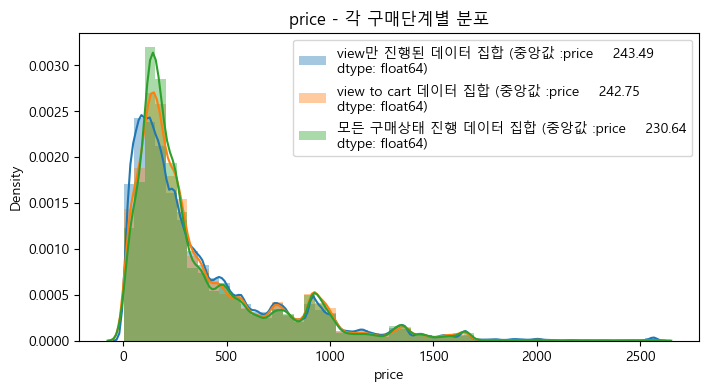

In [34]:
plt.figure(figsize=(8, 4))

# 세 구매단계 집단의 분포 시각화
var = 'price'
sns.distplot(funnel_not[var], kde=True, label=f"view만 진행된 데이터 집합 (중앙값 :{np.round(funnel_not[var].median(),2)})")
sns.distplot(view_to_cart[var], kde=True, label=f"view to cart 데이터 집합 (중앙값 :{np.round(view_to_cart[var].median(),2)})")
sns.distplot(view_to_cart_purchase[var], kde=True, label=f"모든 구매상태 진행 데이터 집합 (중앙값 :{np.round(view_to_cart_purchase[var].median(),2)})")

plt.title(f'{var} - 각 구매단계별 분포')
plt.legend()
plt.xlabel(var)
plt.ylabel('Density')
plt.show()

- 각 단계별로 구매한 제품의 가격 중앙값이 내려가고 있음
1. View 단계에서 비싼 가격을 보고 구매를 망설임
2. 장바구니 담는 제품은 조금더 싼가격(더 저렴한 대안)
3. 최종 구매 단계에서는 더 낮아진 가격대(여러 요소 고려<-저렴한 가격, 진짜 필요한가?)

**각 집단 차이 분석**

In [41]:
from scipy.stats import shapiro

# 정규성 검정
only_view = funnel_not['price']
view_cart = view_to_cart['price']
view_cart_pur = view_to_cart_purchase['price']

stat_1, pvalue_1 = shapiro(only_view)
stat_2, pvalue_2 = shapiro(view_cart)
stat_3, pvalue_3 = shapiro(view_cart_pur)

print('## 정규성 검정 결과')
print('view p-value: {:.4f}'.format(pvalue_1))
print('cart p-value: {:.4f}'.format(pvalue_2))
print('purchase p-value: {:.4f}'.format(pvalue_3))

## 정규성 검정 결과
view p-value: 0.0000
cart p-value: 0.0000
purchase p-value: 0.0000


- 그래프& 분석 결과 모두 확인 결과, 정규성을 가지지 않음 -> 비모수 검정

In [49]:
from scipy.stats import kruskal

# 크루스칼 왈리스 검정
stat, pvalue = kruskal(only_view, view_cart, view_cart_pur)
print(pvalue[0])

6.631812275793366e-53


- 크루스칼 왈리스 검정 결과, 집단간 가격 차이가 있다고 볼 수 있음(가격이 구매행동에 영향을 끼침) -> 사후분석 진행

In [61]:
# 각 구매 상태 단계 집단
df_view = pd.DataFrame({'price': only_view['price'].reset_index(drop=True), 'group': np.repeat('view', len(only_view))})
df_cart = pd.DataFrame({'price': view_cart['price'].reset_index(drop=True), 'group': np.repeat('cart', len(view_cart))})
df_purchase = pd.DataFrame({'price': view_cart_pur['price'].reset_index(drop=True), 'group': np.repeat('purchase', len(view_cart_pur))})

combined_data = pd.concat([df_view, df_cart, df_purchase], axis=0, ignore_index=True)

# 확인
combined_data.head()

,price,group
0,1422.100000,view
1,308.630000,view
2,69.170000,view
3,905.213333,view
4,509.563333,view


In [66]:
from scikit_posthocs import posthoc_conover

# Conover's 사후분석
conover_results = posthoc_conover(combined_data, val_col='price', group_col='group')
print('\nConover\'s Test Results:\n', conover_results)


Conover's Test Results:
                   cart      purchase          view
cart      1.000000e+00  6.175974e-26  1.277173e-53
purchase  6.175974e-26  1.000000e+00  5.612347e-01
view      1.277173e-53  5.612347e-01  1.000000e+00


- 순차적인 단계마다 고객이 다시 가격을 재검토 하는 듯 -> 거래정보 기반 고객 군 세분화해 솔루션 개발 필요